# VAE

In [1]:
import timm, torch, random, datasets, math, fastcore.all as fc, numpy as np, matplotlib as mpl, matplotlib.pyplot as plt
import k_diffusion as K, torchvision.transforms as T
import torchvision.transforms.functional as TF,torch.nn.functional as F

from torch.utils.data import DataLoader,default_collate
from pathlib import Path
from torch.nn import init
from fastcore.foundation import L
from torch import nn,tensor
from datasets import load_dataset
from operator import itemgetter
from torcheval.metrics import MulticlassAccuracy,Mean,Metric
from functools import partial
from torch.optim import lr_scheduler
from torch import optim
from einops import rearrange

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.training import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *

/venv/ml/lib/python3.12/site-packages/clip/clip.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import packaging


In [2]:
torch.set_printoptions(precision=4, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'
mpl.rcParams['figure.dpi'] = 70

import logging
logging.disable(logging.WARNING)

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

In [3]:
xl,yl = 'image','label'
name = "fashion_mnist"
bs = 256
dsd = load_dataset(name)

README.md: 0.00B [00:00, ?B/s]

fashion_mnist/train-00000-of-00001.parqu(…):   0%|          | 0.00/30.9M [00:00<?, ?B/s]

fashion_mnist/test-00000-of-00001.parque(…):   0%|          | 0.00/5.18M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [4]:
@inplace
def transformi(b):
    img = [TF.to_tensor(o).flatten() for o in b[xl]]
    b[yl] = b[xl] = img

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=8)

In [5]:
dl = dls.valid
xb,yb = b = next(iter(dl))

## Autoencoder

In [6]:
ni,nh,nl = 784,400,200

In [7]:
def lin(ni, nf, act=nn.SiLU, norm=nn.BatchNorm1d, bias=True):
    layers = nn.Sequential(nn.Linear(ni, nf, bias=bias))
    if act : layers.append(act())
    if norm: layers.append(norm(nf))
    return layers

In [8]:
def init_weights(m, leaky=0.):
    if isinstance(m, (nn.Conv1d,nn.Conv2d,nn.Conv3d,nn.Linear)): init.kaiming_normal_(m.weight, a=leaky)

In [9]:
iw = partial(init_weights, leaky=0.2)

In [10]:
class Autoenc(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = nn.Sequential(lin(ni, nh), lin(nh, nh), lin(nh, nl))
        self.dec = nn.Sequential(lin(nl, nh), lin(nh, nh), lin(nh, ni, act=None))
        iw(self)
        
    def forward(self, x):
        x = self.enc(x)
        return self.dec(x)

In [11]:
opt_func = partial(optim.Adam, eps=1e-5)

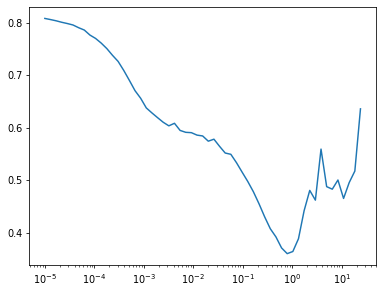

In [12]:
Learner(Autoenc(), dls, nn.BCEWithLogitsLoss(), cbs=[DeviceCB(), MixedPrecision()], opt_func=opt_func).lr_find()

In [15]:
lr = 3e-2
epochs = 20
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched), MixedPrecision()]
model = Autoenc()
learn = Learner(model, dls, nn.BCEWithLogitsLoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.529,0,train
0.468,0,eval
0.400,1,train
0.349,1,eval
0.316,2,train
0.300,2,eval
0.286,3,train
0.284,3,eval
0.276,4,train
0.277,4,eval


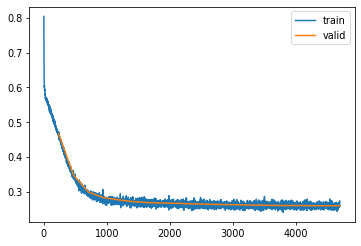

In [16]:
learn.fit(epochs)

In [17]:
torch.save(learn.model, 'models/29-vae-00.pkl')

## Autoencoder Sample

In [18]:
with torch.no_grad(): t = to_cpu(model(xb.cuda()).float())

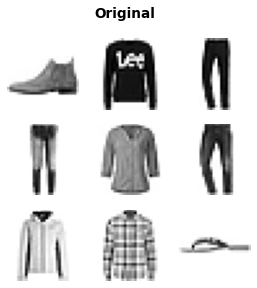

In [19]:
show_images(xb[:9].reshape(-1,1,28,28), imsize=1.5, title='Original');

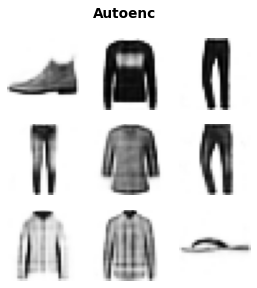

In [20]:
show_images(t[:9].reshape(-1,1,28,28).sigmoid(), imsize=1.5, title='Autoenc');

In [21]:
noise = torch.randn(16, nl).cuda()
with torch.no_grad(): generated_images = model.dec(noise).sigmoid()

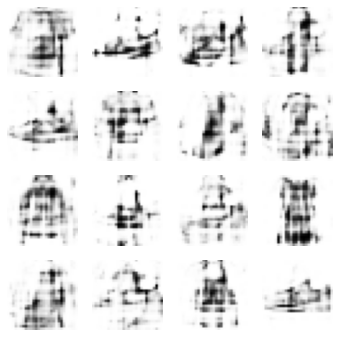

In [22]:
show_images(generated_images.reshape(-1, 1, 28, 28), imsize=1.5)

## VAE

In [23]:
# sd vae is 3 down, 1 no-down, mid, conv, sampling, conv, mid, 3 up, 1 no-up

In [24]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = nn.Sequential(lin(ni, nh), lin(nh, nh))
        self.mu,self.lv = lin(nh, nl, act=None),lin(nh, nl, act=None)
        self.dec = nn.Sequential(lin(nl, nh), lin(nh, nh), lin(nh, ni, act=None))
        iw(self)
        
    def forward(self, x):
        x = self.enc(x)
        mu,lv = self.mu(x),self.lv(x)
        z = mu + (0.5*lv).exp()*torch.randn_like(lv)
        return self.dec(z),mu,lv

In [25]:
def kld_loss(inp, x):
    x_hat,mu,lv = inp
    return -0.5 * (1 + lv - mu.pow(2) - lv.exp()).mean()

def bce_loss(inp, x): return F.binary_cross_entropy_with_logits(inp[0], x)

def vae_loss(inp, x): return kld_loss(inp, x) + bce_loss(inp,x)

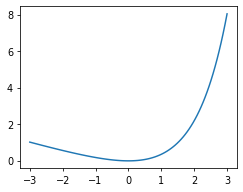

In [26]:
x = torch.linspace(-3,3,100)
plt.figure(figsize=(4,3))
plt.plot(x, -0.5*(1+x-x.exp()));

**Question**: What would happen if the variance of the latents were very low? What if they were very high?

**Bing**: If the variance of the latents were very low, then the encoder distribution would be very peaked and concentrated around the mean. This would make the latent space less diverse and expressive, and limit the ability of the decoder to reconstruct the data accurately. It would also make it harder to generate new data that are different from the training data.

If the variance of the latents were very high, then the encoder distribution would be very spread out and diffuse. This would make the latent space more noisy and random, and reduce the correlation between the latent codes and the data. It would also make it easier to generate new data that are unrealistic or nonsensical.

In [27]:
class FuncMetric(Mean):
    def __init__(self, fn, device=None):
        super().__init__(device=device)
        self.fn = fn

    def update(self, inp, targets): 
        self.weighted_sum += self.fn(inp, targets)
        self.weights += 1

In [28]:
metrics = MetricsCB(kld=FuncMetric(kld_loss), bce=FuncMetric(bce_loss))
opt_func = partial(optim.Adam, eps=1e-5)

In [29]:
lr = 3e-2
epochs = 20
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), ProgressCB(plot=True), metrics, BatchSchedCB(sched), MixedPrecision()]
model = VAE()
learn = Learner(model, dls, vae_loss, lr=lr, cbs=cbs, opt_func=opt_func)

kld,bce,loss,epoch,train
0.428,0.546,0.974,0,train
0.251,0.485,0.736,0,eval
0.099,0.445,0.544,1,train
0.050,0.407,0.457,1,eval
0.034,0.383,0.416,2,train
0.037,0.364,0.400,2,eval
0.035,0.356,0.391,3,train
0.035,0.352,0.387,3,eval
0.036,0.347,0.383,4,train
0.036,0.344,0.380,4,eval


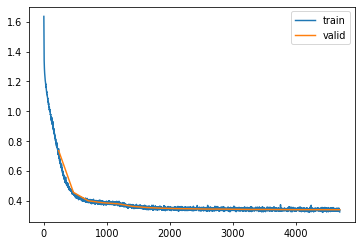

In [30]:
learn.fit(epochs)

In [31]:
torch.save(learn.model, 'models/29-vae-01.pkl')

## VAE Sample

In [32]:
with torch.no_grad(): t,mu,lv = to_cpu(model(xb.cuda()))
t = t.float()

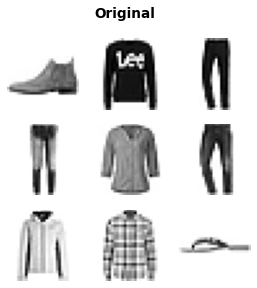

In [33]:
show_images(xb[:9].reshape(-1,1,28,28), imsize=1.5, title='Original');

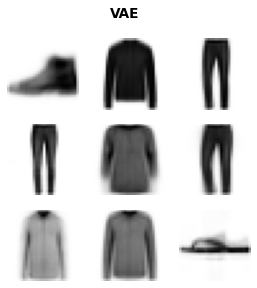

In [34]:
show_images(t[:9].reshape(-1,1,28,28).sigmoid(), imsize=1.5, title='VAE');

In [35]:
noise = torch.randn(16, nl).cuda()
with torch.no_grad(): ims = model.dec(noise).sigmoid()

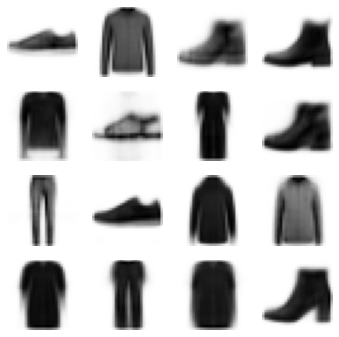

In [36]:
show_images(ims.reshape(-1, 1, 28, 28), imsize=1.5)